In [6]:
#### Import Library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity,calculate_kmo
import xgboost as xgb
from sklearn.model_selection import train_test_split,GridSearchCV,KFold
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,precision_score, recall_score, f1_score,ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import random
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
import itertools

In [8]:
# Get the path of the file
# Current directiory for Jupyter
script_dir = os.getcwd() 

# Check the path whether correct 
print(script_dir)

#Buld corresponding path
file_path = os.path.join(script_dir, "Data")
Original_File_path = os.path.join(file_path, "Original_Data.csv")
Data_Without_Outlier_Path = os.path.join(file_path, "Data_Without_Outlier.csv")

# Test whether path correct
print("Original File Path:", Original_File_path)
print("Data Without Outlier Path:", Data_Without_Outlier_Path)


# Read the csv files
original_data = pd.read_csv(Original_File_path,encoding='utf-8')
data_without_outlier = pd.read_csv(Data_Without_Outlier_Path,encoding='utf-8')

# Check the csv file
print(original_data.head())
print(data_without_outlier.head())

# Check the data
original_data.describe()

C:\Users\jueyo\OneDrive\Desktop\WashU\ESE_417
Original File Path: C:\Users\jueyo\OneDrive\Desktop\WashU\ESE_417\Data\Original_Data.csv
Data Without Outlier Path: C:\Users\jueyo\OneDrive\Desktop\WashU\ESE_417\Data\Data_Without_Outlier.csv
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65 

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [10]:
# the decision tree algorithm
class node:
    def __init__(self, feature=None, bar=None, left=None, right=None, value=None):
        self.feature = feature
        self.bar = bar
        self.left = left
        self.right = right
        self.value = value
class decisiontree:
    def __init__(self,max_depth, min_samples_split):
        self.max_depth=max_depth
        self.min_samples_split=min_samples_split
        self.root=None

    def fit(self,x,y):
        self.root=self.grow_tree(x,y)
    # find left and right leaf for every bar
    def split_before(self,x_col,bar):
        left_ind=np.where(x_col<=bar)[0]
        right_ind=np.where(x_col>bar)[0]
        if len(left_ind)==0 or len(right_ind)==0:
            return None, None
        return left_ind, right_ind
    def entropy(self,x):
        count=np.bincount(x)
        temp=count/len(x)
        sum=-np.sum([p*np.log2(p) for p in temp if p>0])
        return sum
    def gain(self,y,left,right):
        if left is None or right is None:
            return 0
        total_en=self.entropy(y)
        n=len(y)
        n_left,n_right=len(left),len(right)
        if n_left==0 or n_right==0:
            return 0
        minus=(n_left/n)*self.entropy(y[left])+(n_right/n)*self.entropy(y[right])
        return total_en-minus
    def split(self,x,y):
        best_gain=-1
        best_feature, best_bar=None,None
        for i in range(x.shape[1]):
            x_col=x[:,i]
            bar=np.unique(x_col)
            for j in bar:
                left_ind,right_ind=self.split_before(x_col,j)
                gain=self.gain(y,left_ind,right_ind)
                if gain>best_gain:
                    best_feature=i
                    best_bar=j
                    best_gain=gain
        return best_feature,best_bar
                
    def grow_tree(self,x,y,dep=0):
        n_sample, n_feature=x.shape
        # stop
        if dep>=self.max_depth or n_sample<self.min_samples_split or len(np.unique(y)) == 1:
            leaf_label=np.bincount(y).argmax()
            return node(value=leaf_label)
        # how to split
        feature,bar=self.split(x,y)
        if feature is None:
            leaf_label=np.bincount(y).argmax()
            return node(value=leaf_label)
        left_ind,right_ind=self.split_before(x[:,feature],bar)
        if left_ind is None or right_ind is None:
            return node(value=np.bincount(y).argmax())
        left_tree=self.grow_tree(x[left_ind],y[left_ind],dep+1)
        right_tree=self.grow_tree(x[right_ind],y[right_ind],dep+1)
        return node(feature=feature,bar=bar,left=left_tree,right=right_tree)
    def find_value(self,x,node):
        if node.value is not None:
            return node.value
        if x[node.feature]<=node.bar:
            return self.find_value(x,node.left)
        if x[node.feature]>node.bar:
            return self.find_value(x,node.right)
    def predict(self,X):
        return np.array([self.find_value(x,self.root) for x in X])
        

In [12]:
# the random forest algorithm
class randomforest:
    def __init__(self,n_tree,max_depth,min_sample_split,random_seed):
        self.n_tree=n_tree  #numbers of trees
        self.max_depth=max_depth  # the max depth of every tree
        self.min_sample_split=min_sample_split # below this number node cannot be splited
        self.random_seed=random_seed
        self.trees=[]
    def fit(self,x,y):
        x=np.array(x)
        y=np.array(y)
        self.trees=[]
        np.random.seed(self.random_seed)
        for _ in range(self.n_tree):
            # bootstrap
            indexs=np.random.choice(len(x),len(x),replace=True)
            x_selected=x[indexs]
            y_selected=y[indexs]
            # train every tree
            tree=DecisionTreeClassifier(max_depth=self.max_depth, min_samples_split=self.min_sample_split,random_state=self.random_seed,class_weight='balanced')
            #tree=decisiontree(max_depth=self.max_depth,min_samples_split=self.min_sample_split)
            tree.fit(x_selected,y_selected)
            self.trees.append(tree)
            #print('done')

    def predict(self,x):
        x=np.array(x,dtype=np.float64)
        prediction=np.array([tree.predict(x) for tree in self.trees])
        prediction = prediction.astype(int)
        return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=prediction)




In [5]:
#k-forth validation on dataset_without outliers
X=data_without_outlier.iloc[:,0:11]
y=data_without_outlier['quality']
param_grid={
    'n_tree' :[100,200,300,400,500],
    'max_depth' : [10,20,30,40],
    'min_sample_split' : [3,5,7,9],
    'random_seed' : [50,60,70,80]}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
best_k=None
best_sc=-1
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
mean_store=[]
# Iterate the num of tree
for n_tr in param_grid['n_tree'] :
    # Iterate the each depeth
    for max_d in param_grid['max_depth']:
        # Iterate the min sample batch
        for min_s in param_grid['min_sample_split']:
            # Build the random seed
            for ran in param_grid['random_seed']:
                # The set used to store the scores
                scors=[]
                # Based on K - fold algorithm
                for train_ind, val_ind in kf.split(x_train):
                    # Train and test set
                    x_fold_train, x_fold_val = x_train.iloc[train_ind], x_train.iloc[val_ind]
                    y_fold_train, y_fold_val = y_train.iloc[train_ind], y_train.iloc[val_ind]
                    model=randomforest(n_tree=n_tr,max_depth=max_d,min_sample_split=min_s,random_seed=ran)
                    model.fit(x_fold_train,y_fold_train)
                    y_pred=model.predict(x_fold_val)
                    score=accuracy_score(y_fold_val, y_pred)
                    scors.append(score)
                mean=np.mean(scors)
                mean_store.append(mean)
                print(f"Params: n_tree={n_tr}, max_depth={max_d}, min_samples_split={min_s}, random_seed={ran},Accuracy: {mean:.4f}")
                if mean>best_sc:
                    best_sc=mean
                    best_k={'n_tree' :n_tr,  
                           'max_depth': max_d,
                           'min_sample_split' :min_s,
                           'random_seed' : ran}


print("Best Parameters:", best_k)
print("Best Cross-Validation Accuracy:", best_sc)
# Try the best 
best_model=randomforest(n_tree=best_k['n_tree'],max_depth=best_k['max_depth'],min_sample_split=best_k['min_sample_split'],random_seed=best_k['random_seed'])
best_model.fit(x_train, y_train)
y_test_pre=best_model.predict(x_test)
test_accuracy = accuracy_score(y_test, y_test_pre)
print(f"Test Accuracy: {test_accuracy:.4f}")

Params: n_tree=100, max_depth=10, min_samples_split=3, random_seed=50,Accuracy: 0.6794
Params: n_tree=100, max_depth=10, min_samples_split=3, random_seed=60,Accuracy: 0.6864
Params: n_tree=100, max_depth=10, min_samples_split=3, random_seed=70,Accuracy: 0.6716
Params: n_tree=100, max_depth=10, min_samples_split=3, random_seed=80,Accuracy: 0.6692
Params: n_tree=100, max_depth=10, min_samples_split=5, random_seed=50,Accuracy: 0.6786
Params: n_tree=100, max_depth=10, min_samples_split=5, random_seed=60,Accuracy: 0.6778
Params: n_tree=100, max_depth=10, min_samples_split=5, random_seed=70,Accuracy: 0.6645
Params: n_tree=100, max_depth=10, min_samples_split=5, random_seed=80,Accuracy: 0.6669
Params: n_tree=100, max_depth=10, min_samples_split=7, random_seed=50,Accuracy: 0.6755
Params: n_tree=100, max_depth=10, min_samples_split=7, random_seed=60,Accuracy: 0.6763
Params: n_tree=100, max_depth=10, min_samples_split=7, random_seed=70,Accuracy: 0.6638
Params: n_tree=100, max_depth=10, min_sampl

In [14]:
# grid-search on dataset without outliers
X=data_without_outlier.iloc[:,0:11]
y=data_without_outlier['quality']
param_grid={
    'n_tree' :[100,200,300,400,500],
    'max_depth' : [10,20,30,40],
    'min_sample_split' : [3,5,7,9],
    'random_seed' : [50,60,70,80]}

best_k=None
best_sc=-1
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
ac_store=[]
f1_store=[]
for n_tr in param_grid['n_tree'] :
    for max_d in param_grid['max_depth']:
        for min_s in param_grid['min_sample_split']:
            for ran in param_grid['random_seed']:
                model=randomforest(n_tree=n_tr,max_depth=max_d,min_sample_split=min_s,random_seed=ran)
                model.fit(x_train, y_train)
                y_pre=model.predict(x_test)
                score_1=accuracy_score(y_test, y_pre)
                score_2=f1_score(y_test, y_pre,average='weighted')
                ac_store.append(score_1)
                f1_store.append(score_2)
                print(f"Params: n_tree={n_tr}, max_depth={max_d}, min_samples_split={min_s}, random_seed={ran},Accuracy: {score_1:.4f},F1-score={score_2:.4f}")
                #print(classification_report(y_test, y_pre, target_names=['3','4','5','6','7','8']))
                if score_1>best_sc:
                    best_sc=score_1
                    best_k={'n_tree' :n_tr,  
                           'max_depth': max_d,
                           'min_sample_split' :min_s,
                           'random_seed' : ran}


print("Best Parameters:", best_k)
print("Best Cross-Validation Accuracy:", best_sc)

Params: n_tree=100, max_depth=10, min_samples_split=3, random_seed=50,Accuracy: 0.6562,F1-score=0.6476
Params: n_tree=100, max_depth=10, min_samples_split=3, random_seed=60,Accuracy: 0.6750,F1-score=0.6648
Params: n_tree=100, max_depth=10, min_samples_split=3, random_seed=70,Accuracy: 0.6719,F1-score=0.6617
Params: n_tree=100, max_depth=10, min_samples_split=3, random_seed=80,Accuracy: 0.6344,F1-score=0.6227
Params: n_tree=100, max_depth=10, min_samples_split=5, random_seed=50,Accuracy: 0.6594,F1-score=0.6517
Params: n_tree=100, max_depth=10, min_samples_split=5, random_seed=60,Accuracy: 0.6625,F1-score=0.6518
Params: n_tree=100, max_depth=10, min_samples_split=5, random_seed=70,Accuracy: 0.6656,F1-score=0.6597
Params: n_tree=100, max_depth=10, min_samples_split=5, random_seed=80,Accuracy: 0.6500,F1-score=0.6384
Params: n_tree=100, max_depth=10, min_samples_split=7, random_seed=50,Accuracy: 0.6594,F1-score=0.6512
Params: n_tree=100, max_depth=10, min_samples_split=7, random_seed=60,Acc

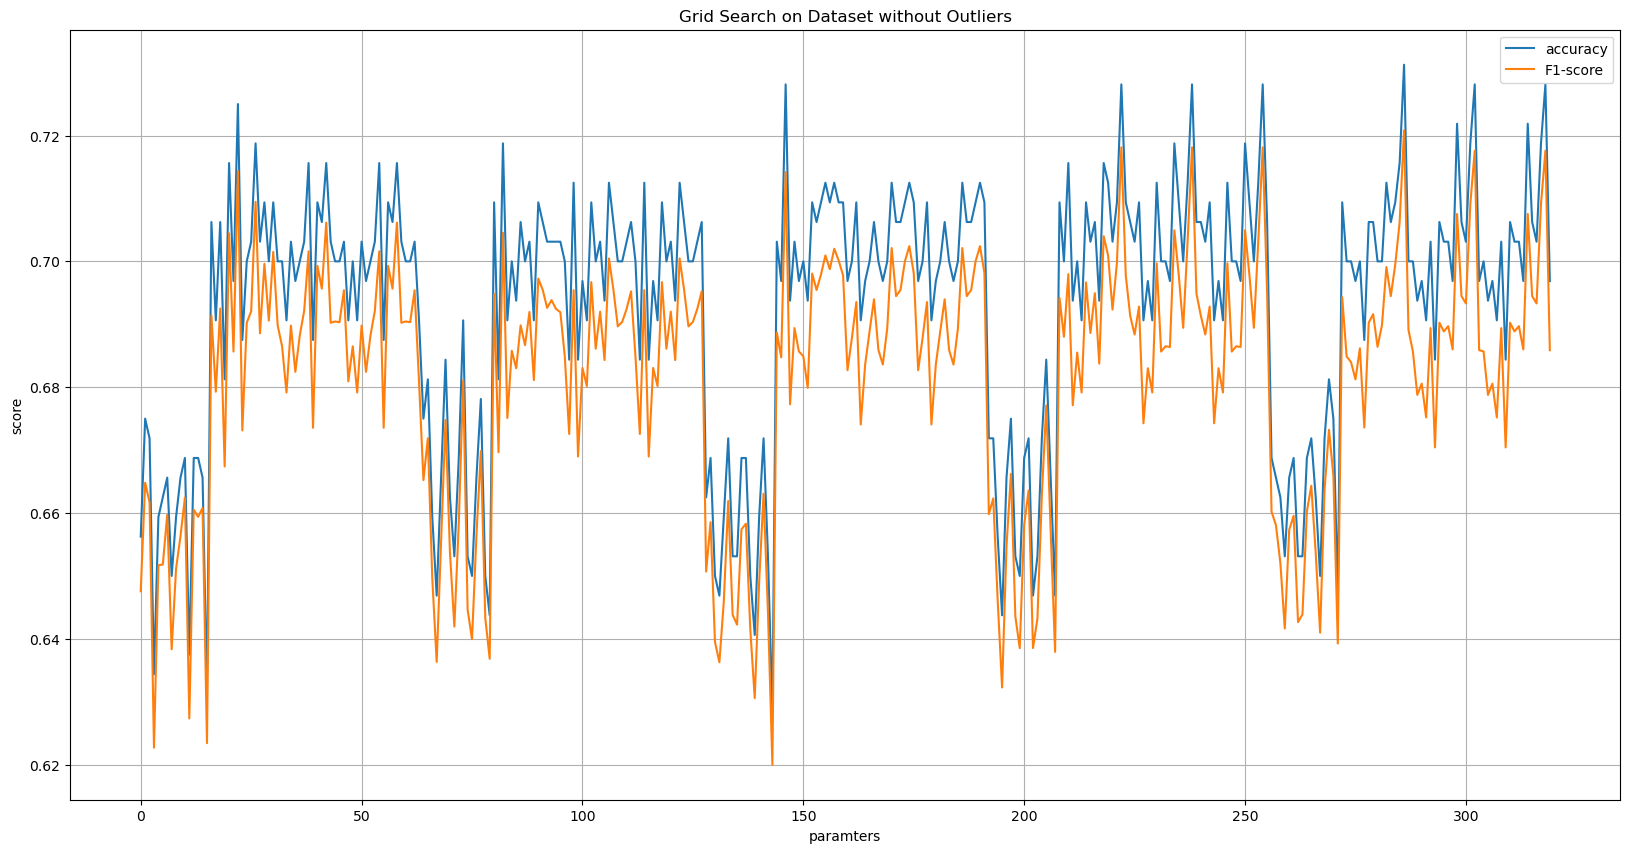

In [16]:
# plot iterations
plt.figure(figsize=(20,10))
plt.plot(range(len(ac_store)),ac_store,label='accuracy')
plt.plot(range(len(f1_store)),f1_store,label='F1-score')
plt.grid()
plt.xlabel('paramters')
plt.ylabel('score')
plt.legend()
plt.title('Grid Search on Dataset without Outliers')
plt.show()

In [18]:
# Set the target and features vector for Data_Without_Outlier
original_x = data_without_outlier.drop(['quality'], axis=1)
original_y = data_without_outlier['quality']

# Split data into training and test sets
original_x_train, original_x_test, original_y_train, original_y_test = train_test_split(
    original_x, original_y, test_size=0.2, random_state=42
)

# Check training and testing data shapes
print(f"Training data shape: {original_x_train.shape}")
print(f"Testing data shape: {original_x_test.shape}")

# Normalization data
scaler = StandardScaler()
original_x_train_scaled = scaler.fit_transform(original_x_train)
original_x_test_scaled = scaler.transform(original_x_test)
# Do the pca process for data

# Call the pca method from packages
# Keep all components
pca = PCA()
pca_process = pca.fit(original_x_train_scaled)

# Use the explained variance 
ev_result = pca.explained_variance_ratio_
#print("featire {i}  ---->    ratio: {}")
print("Exlpained variance raitor")

# Get the sum of explained variance -> cumulative variance 
cv_result = pca.explained_variance_ratio_.cumsum()
# decide how much feature contains
threshold = 0.9
n_features = (cv_result >= threshold).argmax() + 1
print("HOW MANY COMPONENTS KEEPS: ", n_features)
# Update new pca with limited components
pca = PCA(n_components=n_features)
X_reduced = pca.fit_transform(original_x_train_scaled)
print("Find which components has been kept:\n ", pca.components_)
top_features = np.argsort(np.abs(pca.components_), axis=1)[:, ::-1]
print("Find which components has been kept:(Index)\n ", top_features)

# transform the data depend on the  pca
pca.fit(original_x_train_scaled)
original_x_train_scaled_t = pca.transform(original_x_train_scaled)
original_x_test_scaled_t = pca.transform(original_x_test_scaled)



Training data shape: (1279, 11)
Testing data shape: (320, 11)
Exlpained variance raitor
HOW MANY COMPONENTS KEEPS:  7
Find which components has been kept:
  [[ 0.50349721 -0.21946622  0.45736688  0.18873163  0.22226281 -0.06192714
   0.01015142  0.41207779 -0.41950186  0.21187714 -0.09747018]
 [-0.05316909  0.39642069 -0.2014572   0.1420794   0.30136773  0.32592056
   0.44747557  0.29671099 -0.0218534  -0.2406422  -0.48533222]
 [ 0.09817501  0.33379644 -0.18198616 -0.0553366   0.1966896  -0.61884599
  -0.51866334  0.16619321 -0.02964326 -0.28461977 -0.20635978]
 [-0.04327114  0.20349882 -0.0522774   0.78619684  0.09014402 -0.03680007
  -0.0654324   0.16713219  0.32061877  0.12638839  0.41882246]
 [-0.18276764  0.02665526 -0.11708226 -0.26108443  0.55357957 -0.0096233
  -0.0917904   0.02379509  0.21890098  0.71659172 -0.08400105]
 [-0.03371095  0.14888509  0.11775918 -0.01577243  0.59449215  0.03862248
   0.08566158 -0.46572821 -0.37528231 -0.27001498  0.41192551]
 [-0.30657756 -0.64760

In [20]:
# grid search on data after PCA
param_grid={
    'n_tree' :[100,200,300,400,500],
    'max_depth' : [10,20,30,40],
    'min_sample_split' : [3,5,7,9],
    'random_seed' : [50,60,70,80]}

best_k=None
best_sc=-1
ac_store_pca=[]
f1_store_pca=[]
for n_tr in param_grid['n_tree'] :
    for max_d in param_grid['max_depth']:
        for min_s in param_grid['min_sample_split']:
            for ran in param_grid['random_seed']:
                model=randomforest(n_tree=n_tr,max_depth=max_d,min_sample_split=min_s,random_seed=ran)
                model.fit(original_x_train_scaled_t,original_y_train)
                y_pre=model.predict(original_x_test_scaled_t)
                score_1=accuracy_score(original_y_test, y_pre)
                score_2=f1_score(original_y_test, y_pre,average='weighted')
                ac_store_pca.append(score_1)
                f1_store_pca.append(score_2)
                print(f"Params: n_tree={n_tr}, max_depth={max_d}, min_samples_split={min_s}, random_seed={ran},Accuracy: {score_1:.4f},F1-score={score_2:.4f}")
                #print(classification_report(y_test, y_pre, target_names=['3','4','5','6','7','8']))
                if score_1>best_sc:
                    best_sc=score_1
                    best_k={'n_tree' :n_tr,  
                           'max_depth': max_d,
                           'min_sample_split' :min_s,
                           'random_seed' : ran}


print("Best Parameters:", best_k)
print("Best Cross-Validation Accuracy:", best_sc)

Params: n_tree=100, max_depth=10, min_samples_split=3, random_seed=50,Accuracy: 0.6438,F1-score=0.6336
Params: n_tree=100, max_depth=10, min_samples_split=3, random_seed=60,Accuracy: 0.6312,F1-score=0.6200
Params: n_tree=100, max_depth=10, min_samples_split=3, random_seed=70,Accuracy: 0.6562,F1-score=0.6441
Params: n_tree=100, max_depth=10, min_samples_split=3, random_seed=80,Accuracy: 0.6219,F1-score=0.6099
Params: n_tree=100, max_depth=10, min_samples_split=5, random_seed=50,Accuracy: 0.6375,F1-score=0.6301
Params: n_tree=100, max_depth=10, min_samples_split=5, random_seed=60,Accuracy: 0.6375,F1-score=0.6278
Params: n_tree=100, max_depth=10, min_samples_split=5, random_seed=70,Accuracy: 0.6469,F1-score=0.6358
Params: n_tree=100, max_depth=10, min_samples_split=5, random_seed=80,Accuracy: 0.6219,F1-score=0.6146
Params: n_tree=100, max_depth=10, min_samples_split=7, random_seed=50,Accuracy: 0.6312,F1-score=0.6212
Params: n_tree=100, max_depth=10, min_samples_split=7, random_seed=60,Acc

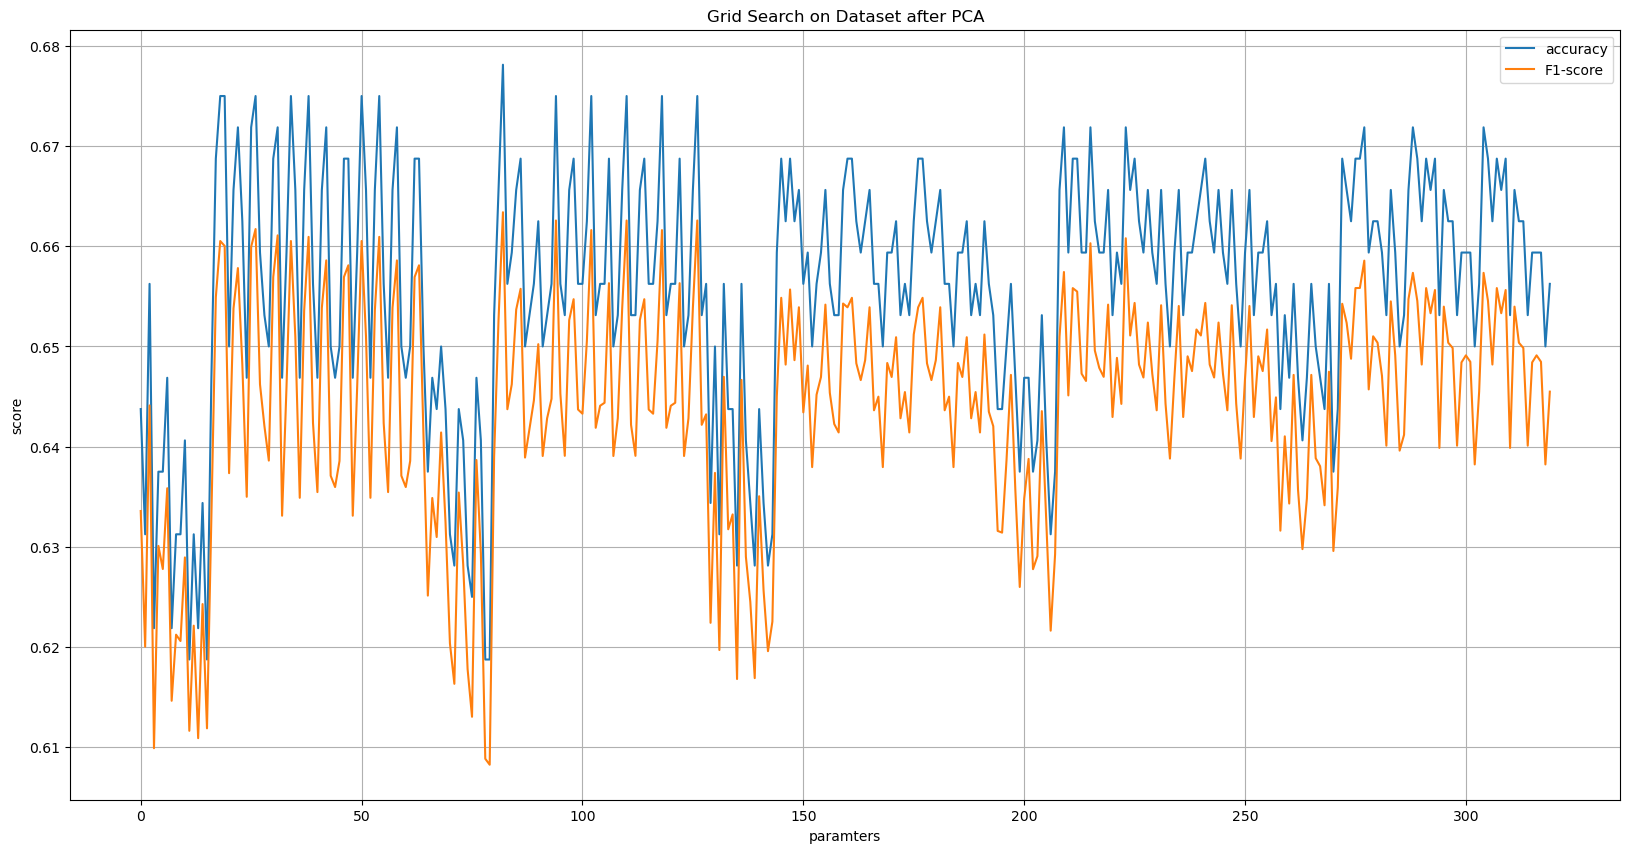

In [22]:
# plot iterations
plt.figure(figsize=(20,10))
plt.plot(range(len(ac_store)),ac_store_pca,label='accuracy')
plt.plot(range(len(f1_store)),f1_store_pca,label='F1-score')
plt.grid()
plt.xlabel('paramters')
plt.ylabel('score')
plt.legend()
plt.title('Grid Search on Dataset after PCA')
plt.show()

In [24]:
# grid search on original data
X=original_data.iloc[:,0:11]
y=original_data['quality']
param_grid={
    'n_tree' :[100,200,300,400,500],
    'max_depth' : [10,20,30,40],
    'min_sample_split' : [3,5,7,9],
    'random_seed' : [50,60,70,80]}

best_k=None
best_sc=-1
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
ac_store_o=[]
f1_store_o=[]
for n_tr in param_grid['n_tree'] :
    for max_d in param_grid['max_depth']:
        for min_s in param_grid['min_sample_split']:
            for ran in param_grid['random_seed']:
                model=randomforest(n_tree=n_tr,max_depth=max_d,min_sample_split=min_s,random_seed=ran)
                model.fit(x_train, y_train)
                y_pre=model.predict(x_test)
                score_1=accuracy_score(y_test, y_pre)
                score_2=f1_score(y_test, y_pre,average='weighted')
                ac_store_o.append(score_1)
                f1_store_o.append(score_2)
                print(f"Params: n_tree={n_tr}, max_depth={max_d}, min_samples_split={min_s}, random_seed={ran},Accuracy: {score_1:.4f},F1-score={score_2:.4f}")
                #print(classification_report(y_test, y_pre, target_names=['3','4','5','6','7','8']))
                if score_1>best_sc:
                    best_sc=score_1
                    best_k={'n_tree' :n_tr,  
                           'max_depth': max_d,
                           'min_sample_split' :min_s,
                           'random_seed' : ran}


print("Best Parameters:", best_k)
print("Best Cross-Validation Accuracy:", best_sc)


Params: n_tree=100, max_depth=10, min_samples_split=3, random_seed=50,Accuracy: 0.6344,F1-score=0.6243
Params: n_tree=100, max_depth=10, min_samples_split=3, random_seed=60,Accuracy: 0.6438,F1-score=0.6309
Params: n_tree=100, max_depth=10, min_samples_split=3, random_seed=70,Accuracy: 0.6281,F1-score=0.6163
Params: n_tree=100, max_depth=10, min_samples_split=3, random_seed=80,Accuracy: 0.6188,F1-score=0.6028
Params: n_tree=100, max_depth=10, min_samples_split=5, random_seed=50,Accuracy: 0.6312,F1-score=0.6215
Params: n_tree=100, max_depth=10, min_samples_split=5, random_seed=60,Accuracy: 0.6375,F1-score=0.6225
Params: n_tree=100, max_depth=10, min_samples_split=5, random_seed=70,Accuracy: 0.6406,F1-score=0.6336
Params: n_tree=100, max_depth=10, min_samples_split=5, random_seed=80,Accuracy: 0.6281,F1-score=0.6139
Params: n_tree=100, max_depth=10, min_samples_split=7, random_seed=50,Accuracy: 0.6406,F1-score=0.6304
Params: n_tree=100, max_depth=10, min_samples_split=7, random_seed=60,Acc

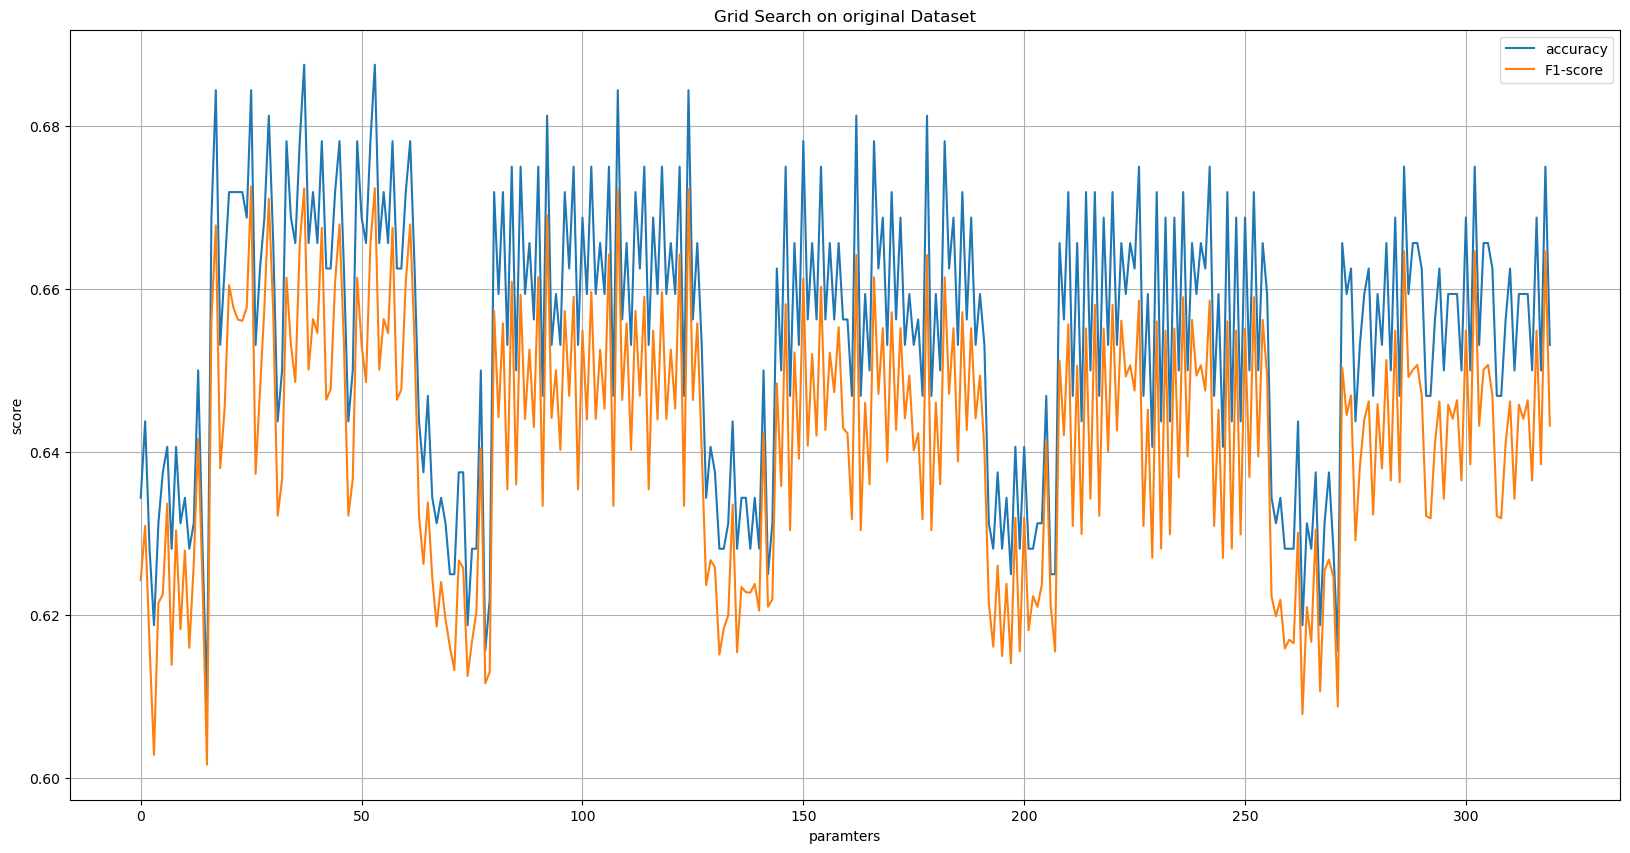

In [26]:
# plot iterations
plt.figure(figsize=(20,10))
plt.plot(range(len(ac_store_o)),ac_store_o,label='accuracy')
plt.plot(range(len(f1_store_o)),f1_store_o,label='F1-score')
plt.grid()
plt.xlabel('paramters')
plt.ylabel('score')
plt.legend()
plt.title('Grid Search on original Dataset')
plt.show()

In [ ]:
#Above 3 pictures summarize the performance metrics for the original dataset, 
#the dataset without outliers, and the dataset after PCA transformation.
#The X-axis in the graphs represents combinations of the selected parameters, while the Y-axis represents the accuracy and F1-score,
#shown as blue and yellow lines, respectively.


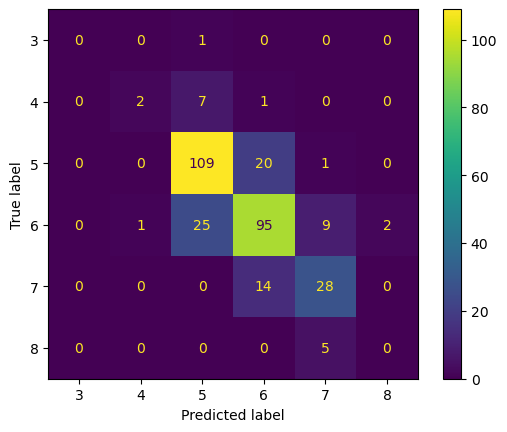

In [28]:
# best model
X=data_without_outlier.iloc[:,0:11]
y=data_without_outlier['quality']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model=randomforest(n_tree=500,max_depth=20,min_sample_split=9,random_seed=70)
model.fit(x_train, y_train)
y_pre=model.predict(x_test)
confusion_matrix = confusion_matrix(y_test, y_pre)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [3, 4,5,6,7,8])

cm_display.plot()
plt.show()